# Atividade 01 - Parte 01 - Inventário de emissões utilizando Python
Foi utilizado o capítulo 10.6 da AP42, pois a empresa fabrica MDF. https://www.epa.gov/sites/default/files/2020-10/documents/c10s0603.pdf

In [ ]:
Fatores de emissão (FE) foram convertidos da seguinte maneira:

-Caso A: FE em lb/ODT = 0.5 kg/Mg = 0.35 kg/m3 (pois densidade do MDF = 700kg/m3)

-Caso B: FE em lb/MSF 3/4 = 0.26 kg/m3 

-Caso C: FE em lb/MSF = 0.0049 kg/m2 = 0.27 kg/m3 (pois espessura do MDF = 0.018m)

Taxa de atividade = 1.140 milhão m3/ano

1 - Planilhar em arquivo .csv os fatores de emissão para cada processo do seu empreendimento (linhas) e para cada poluente (colunas).

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import os

#dados de entrada
ta = 1140000 # taxa de atividade em m3/ano
path = "C:\ENS5173\Dados\FE.csv"
fe = pd.read_csv(path) # fatores de emissao em kg/m3 
print(fe) 

                                              Source      PM  PM-10    NOX  \
0  Tube dryer, direct wood-fired, blowline blend,...  3.6400  0.560    NaN   
1              Hot press, UF resin (SCC 3-07-009-60)  0.0468  0.039  0.039   
2  Former with blowline blend, UF resin (SCC 3-07...     NaN    NaN    NaN   
3                           Sander (SCC 3-07-009-83)     NaN    NaN    NaN   
4                   Saw and hogger (SCC 3-07-009-84)     NaN    NaN    NaN   

        CO  VOC as propane  
0  1.40000        2.100000  
1  0.00884        0.208000  
2      NaN        0.023450  
3      NaN        0.001782  
4      NaN        0.035100  


2- Elaborar uma função para ler a planilha dos fatores de emissão e estimar a emissão com base na taxa de atividade do empreendimento. 

In [25]:
def emis(FE, TA):
    emis = pd.DataFrame()
    cols_numericas = FE.select_dtypes(np.float64).columns
    emis = FE[cols_numericas] * TA # multiplica todas as colunas numericas de FE pela TA
    emis = emis.set_index(FE['Source']) # coloca os processos no index 
    return emis

emissoes = emis(fe, ta) # chamando a funcao
print(emissoes) 

                                                           PM     PM-10  \
Source                                                                    
Tube dryer, direct wood-fired, blowline blend, ...  4149600.0  638400.0   
Hot press, UF resin (SCC 3-07-009-60)                 53352.0   44460.0   
Former with blowline blend, UF resin (SCC 3-07-...        NaN       NaN   
Sander (SCC 3-07-009-83)                                  NaN       NaN   
Saw and hogger (SCC 3-07-009-84)                          NaN       NaN   

                                                        NOX         CO  \
Source                                                                   
Tube dryer, direct wood-fired, blowline blend, ...      NaN  1596000.0   
Hot press, UF resin (SCC 3-07-009-60)               44460.0    10077.6   
Former with blowline blend, UF resin (SCC 3-07-...      NaN        NaN   
Sander (SCC 3-07-009-83)                                NaN        NaN   
Saw and hogger (SCC 3-07-009-8

3- Elaborar uma função para criar uma variabilidade na taxa de atividade do empreendimento, com componentes aleatória e sazonal (com base nas datas do ano de 2023).

In [26]:
def variabilidade(TA):
    datas = pd.date_range(start='2023-01-01', end='2023-12-31', freq='H') # intervalo de datas
    df = pd.DataFrame({'Data': datas}) # DataFrame com as datas
    df['Mes'] = df['Data'].dt.month # nova coluna com os meses no DataFrame
    sazonalidade = np.cos((2*np.pi)*df['Mes']/12) # funcao que modela a sazonalidade 
    df['sazonalidade'] = sazonalidade + 1 # variabilidade da TA entre os meses (componente sazonal)
    # variabilidade da TA entre as horas (componente aleatoria), metodo de Monte-Carlo:
    atvMin = (ta/8760)*min(df['sazonalidade'])
    atvMax = (ta/8760)*max(df['sazonalidade']) # obs: 1ano = 8760 horas
    n = df.shape[0] # Extraindo o número de linhas/número de datas
    atv = (atvMax - atvMin)*np.random.rand(n) + atvMin # Criando atividade aleatória
    df['atividade'] = atv  
    df['aleatorioSazonal'] = df['atividade'] * df['sazonalidade'] # Valores aleatórios com sazonalidade 
    return df

dados = variabilidade(ta) # chamando a funcao
dados

,Data,Mes,sazonalidade,atividade,aleatorioSazonal
0,2023-01-01 00:00:00,1,1.866025,68.252163,127.360269
1,2023-01-01 01:00:00,1,1.866025,219.891636,410.323379
2,2023-01-01 02:00:00,1,1.866025,124.299989,231.946937
3,2023-01-01 03:00:00,1,1.866025,226.692240,423.013478
4,2023-01-01 04:00:00,1,1.866025,240.520133,448.816678
...,...,...,...,...,...
8732,2023-12-30 20:00:00,12,2.000000,95.442084,190.884168
8733,2023-12-30 21:00:00,12,2.000000,114.214702,228.429404
8734,2023-12-30 22:00:00,12,2.000000,51.811808,103.623615
8735,2023-12-30 23:00:00,12,2.000000,18.320176,36.640353


4- Estimar as emissões com a função criada em 2  com os dados de entrada criados em 3.

Obs: cada linha da coluna dados['aleatorioSazonal'] é uma TA, portanto a função emis será aplicada "i" vezes e os resultados serão adicionados ao df_concatenado. 

In [27]:
df_concatenado = pd.DataFrame()
for i in range(len(dados['aleatorioSazonal'])): 
    aux = emis(fe, dados['aleatorioSazonal'][i])
    df_concatenado = pd.concat([df_concatenado, aux], ignore_index=True)
    
df_concatenado 

,PM,PM-10,NOX,CO,VOC as propane
0,463.591379,71.321751,NaN,178.304377,267.456565
1,5.960461,4.967050,4.967050,1.125865,26.490936
2,NaN,NaN,NaN,NaN,2.986598
3,NaN,NaN,NaN,NaN,0.226956
4,NaN,NaN,NaN,NaN,4.470345
...,...,...,...,...,...
43680,1216.670236,187.180036,NaN,467.950091,701.925136
43681,15.642903,13.035753,13.035753,2.954771,69.524013
43682,NaN,NaN,NaN,NaN,7.838164
43683,NaN,NaN,NaN,NaN,0.595634


5- Elaborar figuras e interpretar os resultados. 

    Qual é o processo do empreendimento que possui maior emissão? 

    Qual a variabilidade temporal da taxa de atividade?

"dados" traz informações de hora em hora ao longo de doze meses, logo o gráfico gerado mostrará:
    a) componente sazonal (variabilidade entre meses), vista no perfil da curva (função cosseno) e 
    b) componente aleatória (variabilidade entre horas), vista no eixo y.

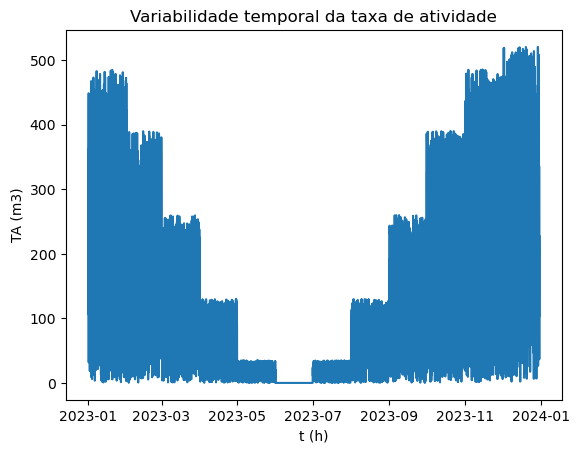

In [28]:
plt.plot(dados['Data'], dados['aleatorioSazonal']) 
plt.xlabel('t (h)')
plt.ylabel('TA (m3)')
plt.title('Variabilidade temporal da taxa de atividade')
plt.show() 

    Qual a soma das emissões considerando todos os processos? Qual a emissão média, mínima e máxima (unidades sempre em gramas por segundo - g/s)?

df_concatenado traz as emissões de hora em hora, ao longo de doze meses, em kg/h. (1kg/h = 0.28g/s)

In [36]:
resultados = pd.DataFrame()

# soma, media, minimo e maximo de emissoes de cada poluente considerando todos os processos: 
soma = (df_concatenado['PM'].sum(), df_concatenado['PM-10'].sum(), df_concatenado['NOX'].sum(), df_concatenado['CO'].sum(), df_concatenado['VOC as propane'].sum())
media = (np.mean(df_concatenado['PM']), np.mean(df_concatenado['PM-10']), np.mean(df_concatenado['NOX']), np.mean(df_concatenado['CO']), np.mean(df_concatenado['VOC as propane']))
minimo = (df_concatenado['PM'].min(), df_concatenado['PM-10'].min(), df_concatenado['NOX'].min(), df_concatenado['CO'].min(), df_concatenado['VOC as propane'].min())
maximo = (df_concatenado['PM'].max(), df_concatenado['PM-10'].max(), df_concatenado['NOX'].max(), df_concatenado['CO'].max(), df_concatenado['VOC as propane'].max())

resultados = pd.DataFrame(data=(soma, media, minimo, maximo), columns=df_concatenado.columns) # coloca os valores no dataframe 
resultados['Emissões (g/s)'] = ('Soma', 'Média', 'Mínimo', 'Máximo') # essa coluna será adicionada ao index e posteriormente excluída 
resultados = resultados.set_index(resultados['Emissões (g/s)']) 
resultados = resultados.drop(columns='Emissões (g/s)') 
resultados = 0.28*resultados 

resultados 


,PM,PM-10,NOX,CO,VOC as propane
Emissões (g/s),,,,,
Soma,1.160092e+06,188481.926368,12271.778178,443306.973530,745221.665507
Média,6.638961e+01,10.786421,1.404576,25.369519,17.058983
Mínimo,0.000000e+00,0.000000,0.000000,0.000000,0.000000
Máximo,5.305421e+02,81.621868,5.684380,204.054671,306.082007
